In [1]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=1b144a49633980fdae3eeee28b4cafbcade532a12245026075002e3aa1e46d43
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from torch.optim import Adam  
from torchvision import transforms  
from torch.utils.data import DataLoader, Dataset  
from efficientnet_pytorch import EfficientNet  
from PIL import Image  
from sklearn.utils.class_weight import compute_class_weight  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
training_df = pd.read_csv('/kaggle/input/butterfly-image-classification/Training_set.csv')
testing_df = pd.read_csv('/kaggle/input/butterfly-image-classification/Testing_set.csv')

training_df.head(), testing_df.head()

(      filename                     label
 0  Image_1.jpg          SOUTHERN DOGFACE
 1  Image_2.jpg                    ADONIS
 2  Image_3.jpg            BROWN SIPROETA
 3  Image_4.jpg                   MONARCH
 4  Image_5.jpg  GREEN CELLED CATTLEHEART,
       filename
 0  Image_1.jpg
 1  Image_2.jpg
 2  Image_3.jpg
 3  Image_4.jpg
 4  Image_5.jpg)

In [4]:
missing_values = training_df.isnull().sum()

missing_values

filename    0
label       0
dtype: int64

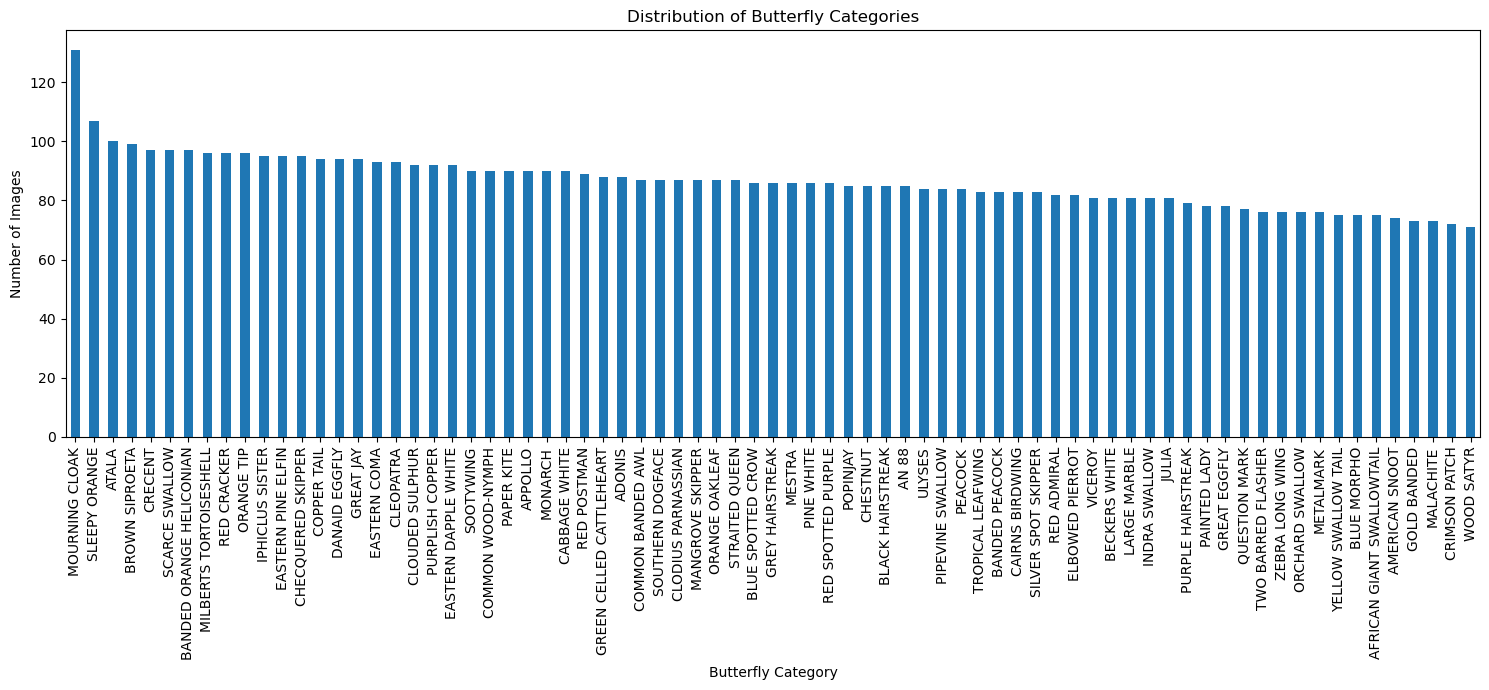

In [5]:
plt.figure(figsize=(15, 7))
training_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

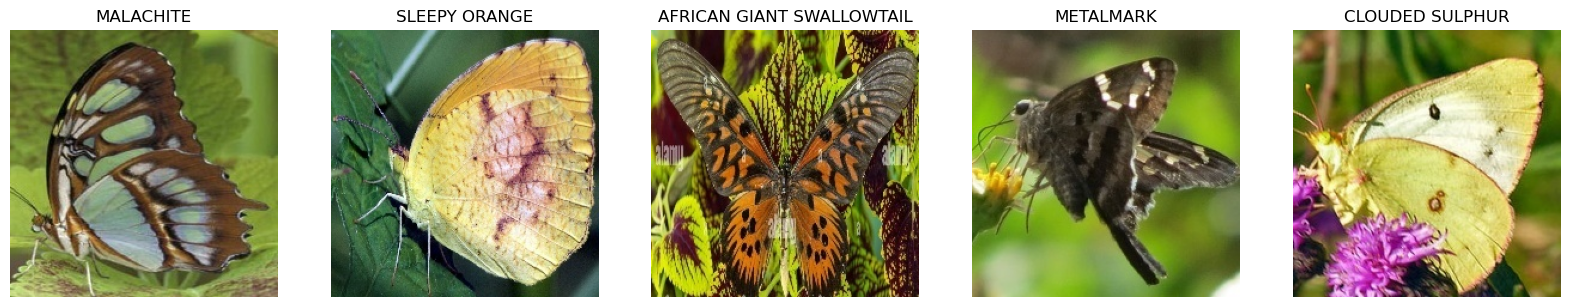

In [6]:
sample_images = random.sample(list(training_df['filename']), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img_name in zip(axes, sample_images):
    img_path = os.path.join('/kaggle/input/butterfly-image-classification/train', img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(training_df[training_df['filename'] == img_name]['label'].values[0])
    ax.axis('off')

plt.tight_layout

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_path = '/kaggle/input/butterfly-image-classification/'
training_df = pd.read_csv(dataset_path + 'Training_set.csv')

IMG_WIDTH = 150
IMG_HEIGHT = 150

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).resize((IMG_WIDTH, IMG_HEIGHT))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_image_paths = [os.path.join(dataset_path + 'train', fname) for fname in training_df['filename']]
labels = training_df['label'].values

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.FloatTensor(class_weights)
class_weights = class_weights.to(device)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels
)

train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(X_train_split, y_train_split, transform=train_transforms)
val_dataset = CustomDataset(X_val_split, y_val_split, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Using device: cuda:0


In [8]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=75):
        super(CustomEfficientNet, self).__init__()

        self.base_model = EfficientNet.from_pretrained('efficientnet-b2')

        num_features = self.base_model._fc.in_features

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(num_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

model = CustomEfficientNet().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=5e-4)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 53.3MB/s]


Loaded pretrained weights for efficientnet-b2


In [9]:
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_train_acc = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_train_acc += accuracy(outputs, labels)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_train_acc / len(train_loader))

    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            running_val_acc += accuracy(outputs, labels)

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(running_val_acc / len(val_loader))

    print(f"Epoch: {epoch+1} | train_loss: {train_losses[-1]:.4f} | train_acc: {train_accuracies[-1]:.4f} | val_loss: {val_losses[-1]:.4f} | val_acc: {val_accuracies[-1]:.4f}")

torch.save(model.state_dict(), '/kaggle/working/efficientnet_model.pth')

Epoch 1 Validation: 100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


Epoch: 1 | train_loss: 3.2386 | train_acc: 0.2986 | val_loss: 1.8723 | val_acc: 0.6262


Epoch 2 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Epoch: 2 | train_loss: 1.2591 | train_acc: 0.7629 | val_loss: 0.7905 | val_acc: 0.8452


Epoch 3 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Epoch: 3 | train_loss: 0.6239 | train_acc: 0.8802 | val_loss: 0.5227 | val_acc: 0.8865


Epoch 4 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Epoch: 4 | train_loss: 0.3805 | train_acc: 0.9206 | val_loss: 0.3779 | val_acc: 0.9052


Epoch 5 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


Epoch: 5 | train_loss: 0.2716 | train_acc: 0.9437 | val_loss: 0.3511 | val_acc: 0.9170


Epoch 6 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Epoch: 6 | train_loss: 0.1898 | train_acc: 0.9616 | val_loss: 0.3907 | val_acc: 0.9052


Epoch 7 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]


Epoch: 7 | train_loss: 0.1667 | train_acc: 0.9646 | val_loss: 0.4076 | val_acc: 0.9080


Epoch 8 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Epoch: 8 | train_loss: 0.1198 | train_acc: 0.9744 | val_loss: 0.3778 | val_acc: 0.9131


Epoch 9 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]


Epoch: 9 | train_loss: 0.0965 | train_acc: 0.9817 | val_loss: 0.3984 | val_acc: 0.9103


Epoch 10 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch: 10 | train_loss: 0.1058 | train_acc: 0.9745 | val_loss: 0.4491 | val_acc: 0.9028


Epoch 11 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch: 11 | train_loss: 0.1003 | train_acc: 0.9784 | val_loss: 0.4497 | val_acc: 0.9021


Epoch 12 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch: 12 | train_loss: 0.0902 | train_acc: 0.9777 | val_loss: 0.4269 | val_acc: 0.9082


Epoch 13 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch: 13 | train_loss: 0.0871 | train_acc: 0.9790 | val_loss: 0.4444 | val_acc: 0.9079


Epoch 14 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


Epoch: 14 | train_loss: 0.1066 | train_acc: 0.9724 | val_loss: 0.4213 | val_acc: 0.9086


Epoch 15 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


Epoch: 15 | train_loss: 0.0848 | train_acc: 0.9801 | val_loss: 0.4323 | val_acc: 0.9147


Epoch 16 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Epoch: 16 | train_loss: 0.1056 | train_acc: 0.9739 | val_loss: 0.4649 | val_acc: 0.9036


Epoch 17 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.47it/s]


Epoch: 17 | train_loss: 0.0689 | train_acc: 0.9826 | val_loss: 0.4333 | val_acc: 0.9080


Epoch 18 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Epoch: 18 | train_loss: 0.0823 | train_acc: 0.9811 | val_loss: 0.4017 | val_acc: 0.9125


Epoch 19 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch: 19 | train_loss: 0.0692 | train_acc: 0.9813 | val_loss: 0.4873 | val_acc: 0.9112


Epoch 20 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]


Epoch: 20 | train_loss: 0.0694 | train_acc: 0.9827 | val_loss: 0.4429 | val_acc: 0.9149


Epoch 21 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


Epoch: 21 | train_loss: 0.0688 | train_acc: 0.9848 | val_loss: 0.3816 | val_acc: 0.9140


Epoch 22 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch: 22 | train_loss: 0.0587 | train_acc: 0.9874 | val_loss: 0.3995 | val_acc: 0.9170


Epoch 23 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch: 23 | train_loss: 0.0707 | train_acc: 0.9813 | val_loss: 0.4506 | val_acc: 0.9103


Epoch 24 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


Epoch: 24 | train_loss: 0.0788 | train_acc: 0.9803 | val_loss: 0.4626 | val_acc: 0.9051


Epoch 25 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch: 25 | train_loss: 0.0731 | train_acc: 0.9806 | val_loss: 0.5430 | val_acc: 0.8827


Epoch 26 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.97it/s]


Epoch: 26 | train_loss: 0.0727 | train_acc: 0.9819 | val_loss: 0.4882 | val_acc: 0.9126


Epoch 27 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


Epoch: 27 | train_loss: 0.0721 | train_acc: 0.9805 | val_loss: 0.4657 | val_acc: 0.9119


Epoch 28 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]


Epoch: 28 | train_loss: 0.0754 | train_acc: 0.9818 | val_loss: 0.4442 | val_acc: 0.9186


Epoch 29 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


Epoch: 29 | train_loss: 0.0664 | train_acc: 0.9812 | val_loss: 0.4974 | val_acc: 0.9140


Epoch 30 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Epoch: 30 | train_loss: 0.0752 | train_acc: 0.9815 | val_loss: 0.4648 | val_acc: 0.9095


Epoch 31 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


Epoch: 31 | train_loss: 0.0612 | train_acc: 0.9849 | val_loss: 0.4439 | val_acc: 0.9171


Epoch 32 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.94it/s]


Epoch: 32 | train_loss: 0.0541 | train_acc: 0.9860 | val_loss: 0.4362 | val_acc: 0.9223


Epoch 33 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Epoch: 33 | train_loss: 0.0665 | train_acc: 0.9845 | val_loss: 0.4471 | val_acc: 0.9141


Epoch 34 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]


Epoch: 34 | train_loss: 0.0692 | train_acc: 0.9827 | val_loss: 0.4850 | val_acc: 0.9118


Epoch 35 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch: 35 | train_loss: 0.0516 | train_acc: 0.9862 | val_loss: 0.5250 | val_acc: 0.9088


Epoch 36 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Epoch: 36 | train_loss: 0.0546 | train_acc: 0.9872 | val_loss: 0.5644 | val_acc: 0.8985


Epoch 37 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.11it/s]


Epoch: 37 | train_loss: 0.0455 | train_acc: 0.9889 | val_loss: 0.5109 | val_acc: 0.9074


Epoch 38 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]


Epoch: 38 | train_loss: 0.0494 | train_acc: 0.9888 | val_loss: 0.5097 | val_acc: 0.9126


Epoch 39 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


Epoch: 39 | train_loss: 0.0436 | train_acc: 0.9874 | val_loss: 0.4914 | val_acc: 0.9208


Epoch 40 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Epoch: 40 | train_loss: 0.0287 | train_acc: 0.9928 | val_loss: 0.5649 | val_acc: 0.9119


Epoch 41 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch: 41 | train_loss: 0.0515 | train_acc: 0.9868 | val_loss: 0.5260 | val_acc: 0.9095


Epoch 42 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Epoch: 42 | train_loss: 0.0549 | train_acc: 0.9869 | val_loss: 0.5133 | val_acc: 0.9097


Epoch 43 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


Epoch: 43 | train_loss: 0.0807 | train_acc: 0.9802 | val_loss: 0.5163 | val_acc: 0.9065


Epoch 44 Validation: 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


Epoch: 44 | train_loss: 0.1003 | train_acc: 0.9756 | val_loss: 0.5582 | val_acc: 0.8954


Epoch 45 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.37it/s]


Epoch: 45 | train_loss: 0.0473 | train_acc: 0.9861 | val_loss: 0.4930 | val_acc: 0.9186


Epoch 46 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


Epoch: 46 | train_loss: 0.0398 | train_acc: 0.9902 | val_loss: 0.5834 | val_acc: 0.9013


Epoch 47 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.91it/s]


Epoch: 47 | train_loss: 0.0346 | train_acc: 0.9901 | val_loss: 0.5816 | val_acc: 0.9058


Epoch 48 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


Epoch: 48 | train_loss: 0.0386 | train_acc: 0.9909 | val_loss: 0.5064 | val_acc: 0.9208


Epoch 49 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


Epoch: 49 | train_loss: 0.0399 | train_acc: 0.9899 | val_loss: 0.5318 | val_acc: 0.9185


Epoch 50 Validation: 100%|██████████| 21/21 [00:04<00:00,  4.92it/s]

Epoch: 50 | train_loss: 0.0456 | train_acc: 0.9885 | val_loss: 0.4851 | val_acc: 0.9179


In [10]:
model.load_state_dict(torch.load('/kaggle/working/efficientnet_model.pth'))
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

accuracy_val = accuracy_score(all_true, all_preds)
precision_val = precision_score(all_true, all_preds, average='weighted')
recall_val = recall_score(all_true, all_preds, average='weighted')
f1_val = f1_score(all_true, all_preds, average='weighted')

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1-Score: {f1_val:.4f}")

Validation Accuracy: 0.9185
Validation Precision: 0.9239
Validation Recall: 0.9185
Validation F1-Score: 0.9177


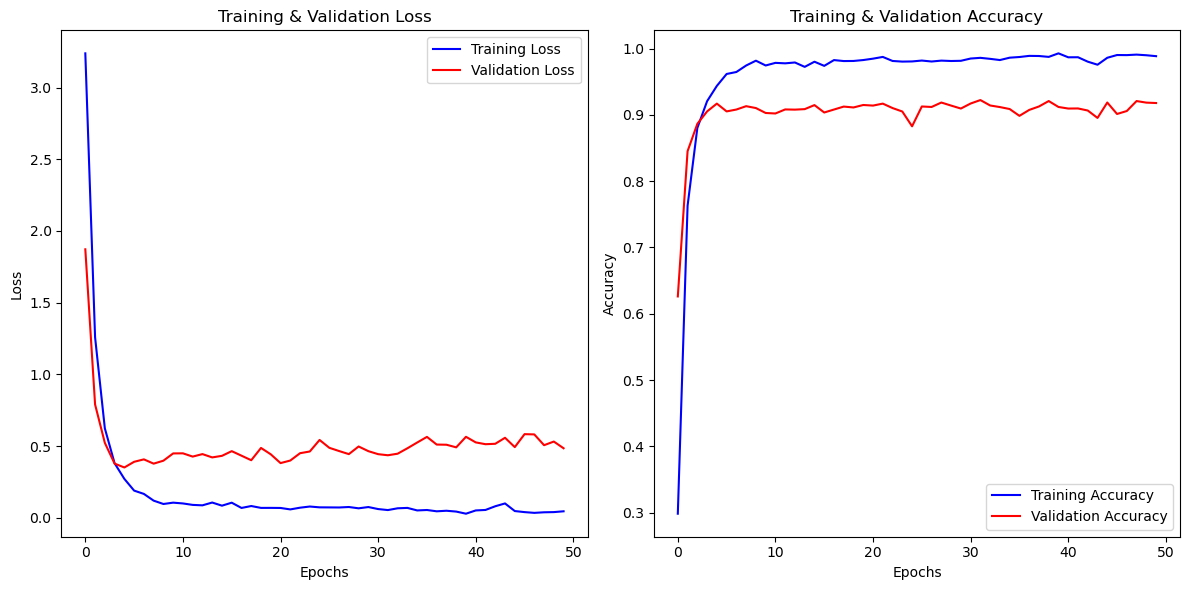

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()